In [17]:
import torch
from torch import nn
import pandas as pd
from torch import optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm
import math
from hilbertcurve.hilbertcurve import HilbertCurve
from math import sqrt
from torchvision import datasets, transforms
import os 

In [2]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 50
PATIANCE = 10
LEARNING_RATE = 1e-3
NUM_CLASSES = 10
PATCH_SIZE = 8
IMAGE_SIZE = 32
IN_CHANNELS = 3
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION = "gelu"
NUM_ENCODERS = 4
EMBEDING_DIMENTION = (PATCH_SIZE**2) * IN_CHANNELS 
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2 

print(NUM_PATCHES)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Cuda Specific 
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Apple Metal Specific 
torch.mps.manual_seed(RANDOM_SEED)

16


In [3]:
if torch.backends.mps.is_available(): 
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

mps


In [4]:
def HilbertIndices(n):
    """
    Generate Hilbert indices for a grid approximating a square layout of patches.

    Args:
    n (int): Total number of patches.

    Returns:
    np.array: Indices sorted according to Hilbert curve distances.
    """
    # Determine the order of the Hilbert curve based on the number of patches
    order = int(np.ceil(np.log2(np.sqrt(n))))
    print("Order is ", order)

    # Initialize Hilbert curve with 2 dimensions and determined order
    hilbert_curve = HilbertCurve(p=order, n=2)
    points = []

    # Determine the maximum x and y values based on the number of patches
    side_length = int(np.ceil(np.sqrt(n)))

    # Collect all points whose Hilbert distances need to be calculated
    for i in range(n):
        x = i // side_length
        y = i % side_length
        points.append([x, y])

    # Calculate the Hilbert distances for all points
    distances = hilbert_curve.distances_from_points(points)

    # Return the indices sorted by their Hilbert distances
    return np.array(distances).argsort()

In [5]:
class PositionalEmbeddingStrategy(nn.Module):
    def forward(self, x):
        raise NotImplementedError("Each Embedding Strategy must implement the forward method.")

In [6]:
class PatchEmbeddingLearnedPositionalEmbedding(PositionalEmbeddingStrategy):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size
            ),
            nn.Flatten(2)
        )

        self.cls_token = nn.Parameter(torch.randn(size=(1, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches + 1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = self.patcher(x).permute(0, 2, 1)
        # print(f"Shape of x after patching and permuting: {x.shape}")
        # print(f"Shape of cls_token: {cls_token.shape}")
        x = torch.cat((cls_token, x), dim=1)
        # print(f"Shape of x after concatenating cls_token: {x.shape}")
        # print(f"Shape of position_embeddings: {self.position_embeddings.shape}")
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x

In [7]:
class PatchEmbeddingNoPositionalEmbedding(PositionalEmbeddingStrategy):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size
            ),
            nn.Flatten(2)
        )

        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat((cls_token, x), dim=1)
        x = self.dropout(x)
        return x

In [8]:
class PatchEmbeddingHilbertPositionalEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels, order):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size
            ),
            nn.Flatten(2)
        )

        # Hilbert curve positional embeddings
        hilbert_indices = HilbertIndices(num_patches)
        position = torch.arange(0, num_patches, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, 2 * embed_dim, 2).float() * (-np.log(10000.0) / (2 * embed_dim)))
        
        # print("Embed dim", embed_dim)

        # Adjust the shape of pe to match the size of position * div_term

        # print("Number of patches", num_patches)
        pe = torch.zeros(num_patches, embed_dim) 
        #assert pe.size() == torch.Size([16, 49]), "Size of pe tensor does not match expected size [16, 49]"

        

        # print("Size of hilbert indicies: ", hilbert_indices.size)
        # print("Size of pe tensor before assignment:", pe.size())
        # print("Size of position * div_term tensor:", (position * div_term).size())
        
        pe = pe[hilbert_indices]  # reorder according to Hilbert curve

        # Adds the sin and cos values for each alternating collumn to add positional embeddings
        pe[:, 0::2] = torch.sin(position * div_term)[:, 0::2]
        pe[:, 1::2] = torch.cos(position * div_term)[:, 1::2]
        # print("Size of pe tensor after assignment:", pe.size())

        #assert pe.size() == torch.Size([NUM_PATCHES, PATCH_SIZE**2])

        # Remove the cls token from positional embeddings
        self.position_embeddings = nn.Parameter(pe[:], requires_grad=False)

        # print("Size of pe tensor after assignment AAAAA:", pe.size())
        # print("Pos embed aaaaaaaa", self.position_embeddings.size())

        # Add cls token separately
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = self.patcher(x).permute(0, 2, 1)

        # print("Shape of x:", x.shape) 
        # print("Shape of x after cat:", x.shape)
        # print("Shape of position_embeddings:", self.position_embeddings.shape)
        x = x + self.position_embeddings
        x = torch.cat((cls_token, x), dim=1)
        x = self.dropout(x)
        return x

In [9]:
class Vit(nn.Module):
    def __init__(self, embedding_strategy, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embedings_block = embedding_strategy

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embedings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0 , :])
        return x

In [10]:
transform_train = transforms.Compose([
    transforms.Resize((32, 32)),  # Ensure the image size is 32x32
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

transform_val_test = transforms.Compose([
    transforms.Resize((32, 32)),  # Ensure the image size is 32x32
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val_test)

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


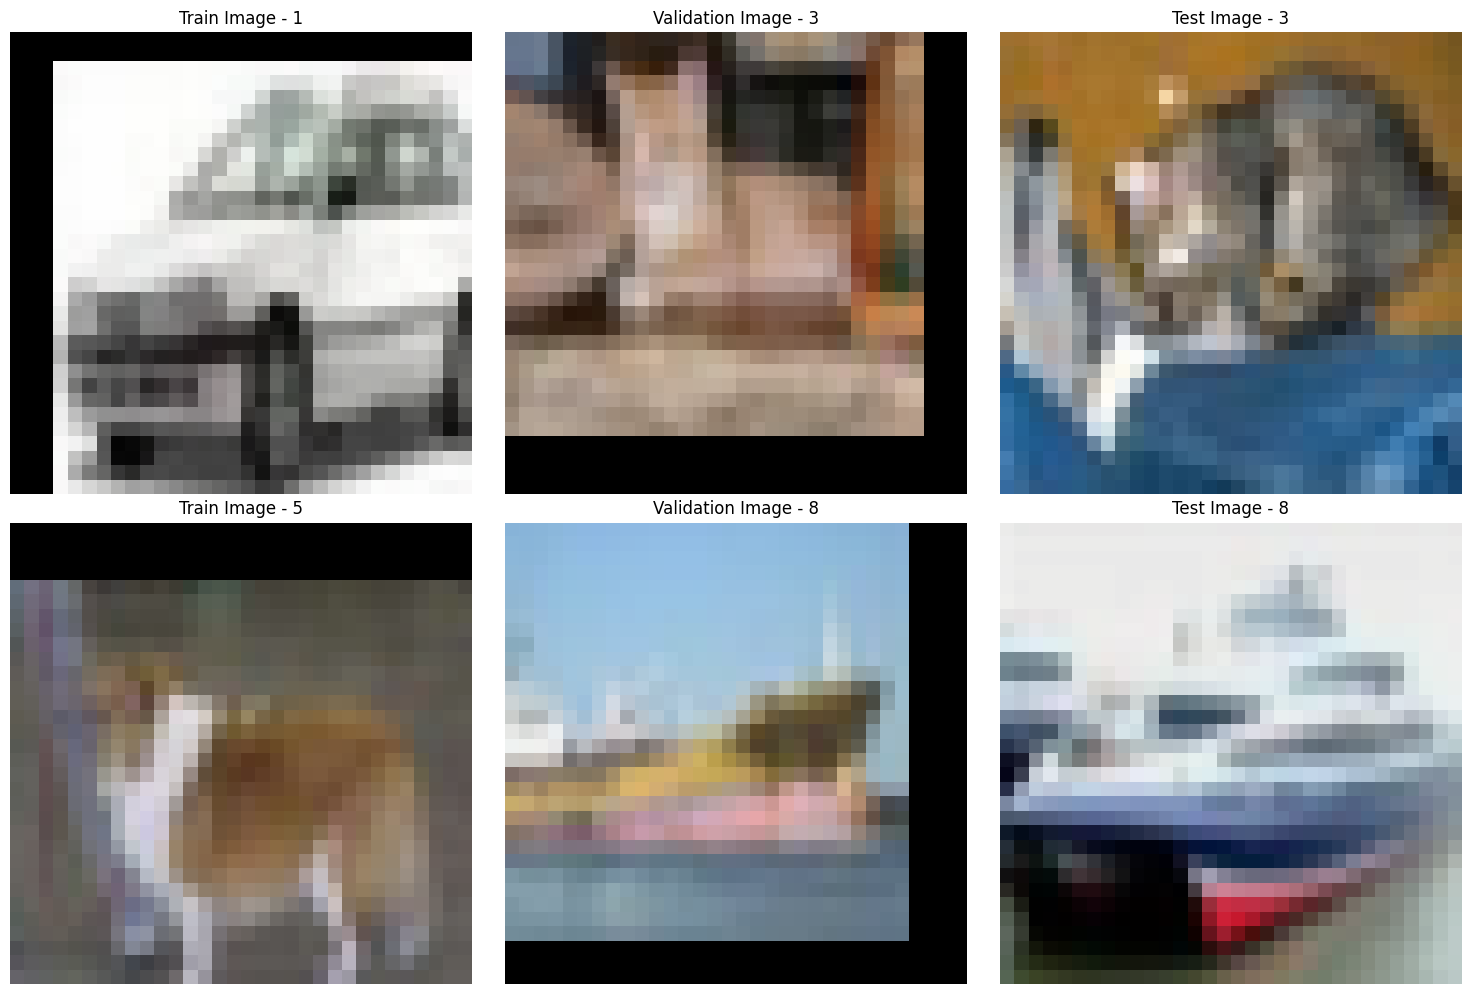

In [11]:
def visualize_data(train_loader, val_loader, test_loader, num_images=2):
    def show_image(image, ax, title):
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.5071, 0.4867, 0.4408])
        std = np.array([0.2675, 0.2565, 0.2761])
        image = std * image + mean  # Unnormalize
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        ax.set_title(title)
        ax.axis('off')
    
    # Get a batch of images from the train, val, and test loaders
    train_iter = iter(train_loader)
    val_iter = iter(val_loader)
    test_iter = iter(test_loader)
    
    # Fetch one batch of images and labels
    train_images, train_labels = next(train_iter)
    val_images, val_labels = next(val_iter)
    test_images, test_labels = next(test_iter)
    
    # Plot images from each dataset
    fig, axarr = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    for i in range(num_images):
        show_image(train_images[i], axarr[i, 0], f"Train Image - {train_labels[i].item()}")
        show_image(val_images[i], axarr[i, 1], f"Validation Image - {val_labels[i].item()}")
        show_image(test_images[i], axarr[i, 2], f"Test Image - {test_labels[i].item()}")
    
    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_data(train_dataloader, val_dataloader, test_dataloader)

In [12]:
def training_loop(embedding_strategy, checkpoint_path):
    model = Vit(embedding_strategy, NUM_PATCHES, IMAGE_SIZE, NUM_CLASSES, PATCH_SIZE, EMBEDING_DIMENTION, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)
    
    best_val_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False
    start = timeit.default_timer()
    
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    
    for epoch in tqdm(range(EPOCHS)):
        model.train()
        train_labels, train_preds = [], []
        train_running_loss = 0
        
        for idx, (img, label) in enumerate(tqdm(train_dataloader, position=0, leave=True)):
            img, label = img.to(device), label.to(device)
            img = img.float()  # Ensure img is float
            label = label.type(torch.long)  # Ensure label is long (for CrossEntropyLoss)
            
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            train_labels.extend(label.cpu().detach())
            train_preds.extend(y_pred_label.cpu().detach())
            
            loss = criterion(y_pred, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_running_loss += loss.item()
        
        train_loss = train_running_loss / len(train_dataloader)
        
        model.eval()
        val_labels, val_preds = [], []
        val_running_loss = 0
        
        with torch.no_grad():
            for idx, (img, label) in enumerate(tqdm(val_dataloader, position=0, leave=True)):
                img, label = img.to(device), label.to(device)
                img = img.float()  # Ensure img is float
                label = label.type(torch.long)  # Ensure label is long (for CrossEntropyLoss)
                
                y_pred = model(img)
                y_pred_label = torch.argmax(y_pred, dim=1)
                
                val_labels.extend(label.cpu().detach())
                val_preds.extend(y_pred_label.cpu().detach())
                
                loss = criterion(y_pred, label)
                val_running_loss += loss.item()
        
        val_loss = val_running_loss / len(val_dataloader)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Epoch {epoch + 1}: New best model saved with val_loss: {val_loss:.4f}')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve == PATIANCE:
            print("Early stopping triggered")
            early_stop = True
            break
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels))
        val_accuracies.append(sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels))
        
        print("-" * 30)
        print(f"Train Loss EPOCH {epoch + 1}: {train_loss:.4f}")
        print(f"Valid Loss EPOCH {epoch + 1}: {val_loss:.4f}")
        print(f"Train Accuracy EPOCH {epoch + 1}: {train_accuracies[-1]:.4f}")
        print(f"Valid Accuracy EPOCH {epoch + 1}: {val_accuracies[-1]:.4f}")
        print("-" * 30)
    
    if not early_stop:
        print("Completed all epochs without early stopping.")
    
    stop = timeit.default_timer()
    print(f"Training Time: {stop - start:.2f}s")
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    fig.suptitle('Training and Validation Metrics')
    
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Loss over epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(train_accuracies, label='Train Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_title('Accuracy over epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.show()
    
    return model

In [13]:
def test_model(model, checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()
    test_running_loss = 0
    test_labels, test_preds = [], []
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for img, label in tqdm(test_dataloader, position=0, leave=True):
            img, label = img.to(device), label.to(device)
            img = img.float()  # Ensure img is float
            label = label.type(torch.long)  # Ensure label is long (for CrossEntropyLoss)
            
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            test_labels.extend(label.cpu().detach())
            test_preds.extend(y_pred_label.cpu().detach())
            
            loss = criterion(y_pred, label)
            test_running_loss += loss.item()
    
    test_loss = test_running_loss / len(test_dataloader)
    test_accuracy = sum(1 for x, y in zip(test_preds, test_labels) if x == y) / len(test_labels)
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

/Users/nihat/mambaforge/envs/bachelor-project/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
  2%|▏         | 1/50 [00:25<20:54, 25.60s/it]

Epoch 1: New best model saved with val_loss: 1.8456
------------------------------
Train Loss EPOCH 1: 2.0125
Valid Loss EPOCH 1: 1.8456
Train Accuracy EPOCH 1: 0.2573
Valid Accuracy EPOCH 1: 0.3174
------------------------------


  4%|▍         | 2/50 [00:50<20:05, 25.12s/it]

Epoch 2: New best model saved with val_loss: 1.6686
------------------------------
Train Loss EPOCH 2: 1.7320
Valid Loss EPOCH 2: 1.6686
Train Accuracy EPOCH 2: 0.3641
Valid Accuracy EPOCH 2: 0.3982
------------------------------


  6%|▌         | 3/50 [01:15<19:43, 25.19s/it]

Epoch 3: New best model saved with val_loss: 1.5863
------------------------------
Train Loss EPOCH 3: 1.6210
Valid Loss EPOCH 3: 1.5863
Train Accuracy EPOCH 3: 0.4073
Valid Accuracy EPOCH 3: 0.4270
------------------------------


  8%|▊         | 4/50 [01:40<19:03, 24.87s/it]

Epoch 4: New best model saved with val_loss: 1.5062
------------------------------
Train Loss EPOCH 4: 1.5460
Valid Loss EPOCH 4: 1.5062
Train Accuracy EPOCH 4: 0.4367
Valid Accuracy EPOCH 4: 0.4528
------------------------------


 10%|█         | 5/50 [02:04<18:31, 24.69s/it]

Epoch 5: New best model saved with val_loss: 1.4851
------------------------------
Train Loss EPOCH 5: 1.4914
Valid Loss EPOCH 5: 1.4851
Train Accuracy EPOCH 5: 0.4570
Valid Accuracy EPOCH 5: 0.4634
------------------------------


 12%|█▏        | 6/50 [02:28<18:01, 24.59s/it]

Epoch 6: New best model saved with val_loss: 1.4668
------------------------------
Train Loss EPOCH 6: 1.4515
Valid Loss EPOCH 6: 1.4668
Train Accuracy EPOCH 6: 0.4752
Valid Accuracy EPOCH 6: 0.4616
------------------------------


 14%|█▍        | 7/50 [02:53<17:36, 24.57s/it]

Epoch 7: New best model saved with val_loss: 1.3979
------------------------------
Train Loss EPOCH 7: 1.4008
Valid Loss EPOCH 7: 1.3979
Train Accuracy EPOCH 7: 0.4925
Valid Accuracy EPOCH 7: 0.4900
------------------------------


 16%|█▌        | 8/50 [03:18<17:15, 24.65s/it]

Epoch 8: New best model saved with val_loss: 1.3669
------------------------------
Train Loss EPOCH 8: 1.3651
Valid Loss EPOCH 8: 1.3669
Train Accuracy EPOCH 8: 0.5058
Valid Accuracy EPOCH 8: 0.5054
------------------------------


 18%|█▊        | 9/50 [03:42<16:50, 24.65s/it]

Epoch 9: New best model saved with val_loss: 1.3295
------------------------------
Train Loss EPOCH 9: 1.3391
Valid Loss EPOCH 9: 1.3295
Train Accuracy EPOCH 9: 0.5163
Valid Accuracy EPOCH 9: 0.5200
------------------------------


 20%|██        | 10/50 [04:08<16:35, 24.89s/it]

------------------------------
Train Loss EPOCH 10: 1.3088
Valid Loss EPOCH 10: 1.3427
Train Accuracy EPOCH 10: 0.5259
Valid Accuracy EPOCH 10: 0.5154
------------------------------


 22%|██▏       | 11/50 [04:33<16:17, 25.07s/it]

Epoch 11: New best model saved with val_loss: 1.3036
------------------------------
Train Loss EPOCH 11: 1.2711
Valid Loss EPOCH 11: 1.3036
Train Accuracy EPOCH 11: 0.5431
Valid Accuracy EPOCH 11: 0.5284
------------------------------


 24%|██▍       | 12/50 [04:58<15:51, 25.03s/it]

Epoch 12: New best model saved with val_loss: 1.2517
------------------------------
Train Loss EPOCH 12: 1.2452
Valid Loss EPOCH 12: 1.2517
Train Accuracy EPOCH 12: 0.5513
Valid Accuracy EPOCH 12: 0.5494
------------------------------


 26%|██▌       | 13/50 [05:22<15:16, 24.76s/it]

------------------------------
Train Loss EPOCH 13: 1.2256
Valid Loss EPOCH 13: 1.2566
Train Accuracy EPOCH 13: 0.5593
Valid Accuracy EPOCH 13: 0.5534
------------------------------


 28%|██▊       | 14/50 [05:47<14:46, 24.61s/it]

Epoch 14: New best model saved with val_loss: 1.2396
------------------------------
Train Loss EPOCH 14: 1.1982
Valid Loss EPOCH 14: 1.2396
Train Accuracy EPOCH 14: 0.5676
Valid Accuracy EPOCH 14: 0.5562
------------------------------


 30%|███       | 15/50 [06:11<14:16, 24.47s/it]

Epoch 15: New best model saved with val_loss: 1.2045
------------------------------
Train Loss EPOCH 15: 1.1748
Valid Loss EPOCH 15: 1.2045
Train Accuracy EPOCH 15: 0.5787
Valid Accuracy EPOCH 15: 0.5708
------------------------------


 32%|███▏      | 16/50 [06:35<13:48, 24.38s/it]

Epoch 16: New best model saved with val_loss: 1.2010
------------------------------
Train Loss EPOCH 16: 1.1510
Valid Loss EPOCH 16: 1.2010
Train Accuracy EPOCH 16: 0.5855
Valid Accuracy EPOCH 16: 0.5728
------------------------------


 34%|███▍      | 17/50 [06:59<13:24, 24.38s/it]

Epoch 17: New best model saved with val_loss: 1.1773
------------------------------
Train Loss EPOCH 17: 1.1332
Valid Loss EPOCH 17: 1.1773
Train Accuracy EPOCH 17: 0.5939
Valid Accuracy EPOCH 17: 0.5768
------------------------------


 36%|███▌      | 18/50 [07:24<13:01, 24.42s/it]

Epoch 18: New best model saved with val_loss: 1.1635
------------------------------
Train Loss EPOCH 18: 1.1158
Valid Loss EPOCH 18: 1.1635
Train Accuracy EPOCH 18: 0.5974
Valid Accuracy EPOCH 18: 0.5860
------------------------------


 38%|███▊      | 19/50 [07:48<12:37, 24.43s/it]

Epoch 19: New best model saved with val_loss: 1.1587
------------------------------
Train Loss EPOCH 19: 1.0874
Valid Loss EPOCH 19: 1.1587
Train Accuracy EPOCH 19: 0.6107
Valid Accuracy EPOCH 19: 0.5830
------------------------------


 40%|████      | 20/50 [08:13<12:13, 24.46s/it]

Epoch 20: New best model saved with val_loss: 1.1537
------------------------------
Train Loss EPOCH 20: 1.0619
Valid Loss EPOCH 20: 1.1537
Train Accuracy EPOCH 20: 0.6201
Valid Accuracy EPOCH 20: 0.5810
------------------------------


 42%|████▏     | 21/50 [08:37<11:51, 24.52s/it]

Epoch 21: New best model saved with val_loss: 1.1336
------------------------------
Train Loss EPOCH 21: 1.0442
Valid Loss EPOCH 21: 1.1336
Train Accuracy EPOCH 21: 0.6241
Valid Accuracy EPOCH 21: 0.5898
------------------------------


 44%|████▍     | 22/50 [09:02<11:27, 24.54s/it]

Epoch 22: New best model saved with val_loss: 1.1148
------------------------------
Train Loss EPOCH 22: 1.0273
Valid Loss EPOCH 22: 1.1148
Train Accuracy EPOCH 22: 0.6271
Valid Accuracy EPOCH 22: 0.6014
------------------------------


 46%|████▌     | 23/50 [09:27<11:03, 24.57s/it]

------------------------------
Train Loss EPOCH 23: 1.0064
Valid Loss EPOCH 23: 1.1184
Train Accuracy EPOCH 23: 0.6396
Valid Accuracy EPOCH 23: 0.6014
------------------------------


 48%|████▊     | 24/50 [09:52<10:41, 24.69s/it]

Epoch 24: New best model saved with val_loss: 1.1011
------------------------------
Train Loss EPOCH 24: 0.9860
Valid Loss EPOCH 24: 1.1011
Train Accuracy EPOCH 24: 0.6474
Valid Accuracy EPOCH 24: 0.6090
------------------------------


 50%|█████     | 25/50 [10:17<10:24, 24.97s/it]

Epoch 25: New best model saved with val_loss: 1.0730
------------------------------
Train Loss EPOCH 25: 0.9694
Valid Loss EPOCH 25: 1.0730
Train Accuracy EPOCH 25: 0.6517
Valid Accuracy EPOCH 25: 0.6230
------------------------------


 52%|█████▏    | 26/50 [10:43<10:03, 25.14s/it]

------------------------------
Train Loss EPOCH 26: 0.9491
Valid Loss EPOCH 26: 1.0867
Train Accuracy EPOCH 26: 0.6607
Valid Accuracy EPOCH 26: 0.6090
------------------------------


 54%|█████▍    | 27/50 [11:08<09:35, 25.04s/it]

------------------------------
Train Loss EPOCH 27: 0.9207
Valid Loss EPOCH 27: 1.1033
Train Accuracy EPOCH 27: 0.6686
Valid Accuracy EPOCH 27: 0.6078
------------------------------


 56%|█████▌    | 28/50 [11:32<09:08, 24.92s/it]

Epoch 28: New best model saved with val_loss: 1.0722
------------------------------
Train Loss EPOCH 28: 0.9048
Valid Loss EPOCH 28: 1.0722
Train Accuracy EPOCH 28: 0.6763
Valid Accuracy EPOCH 28: 0.6244
------------------------------


 58%|█████▊    | 29/50 [11:57<08:41, 24.84s/it]

------------------------------
Train Loss EPOCH 29: 0.8830
Valid Loss EPOCH 29: 1.0952
Train Accuracy EPOCH 29: 0.6834
Valid Accuracy EPOCH 29: 0.6192
------------------------------


 60%|██████    | 30/50 [12:22<08:16, 24.82s/it]

------------------------------
Train Loss EPOCH 30: 0.8761
Valid Loss EPOCH 30: 1.0726
Train Accuracy EPOCH 30: 0.6854
Valid Accuracy EPOCH 30: 0.6222
------------------------------


 62%|██████▏   | 31/50 [12:46<07:51, 24.84s/it]

Epoch 31: New best model saved with val_loss: 1.0641
------------------------------
Train Loss EPOCH 31: 0.8553
Valid Loss EPOCH 31: 1.0641
Train Accuracy EPOCH 31: 0.6941
Valid Accuracy EPOCH 31: 0.6292
------------------------------


 64%|██████▍   | 32/50 [13:11<07:25, 24.75s/it]

------------------------------
Train Loss EPOCH 32: 0.8303
Valid Loss EPOCH 32: 1.0712
Train Accuracy EPOCH 32: 0.7026
Valid Accuracy EPOCH 32: 0.6180
------------------------------


 66%|██████▌   | 33/50 [13:35<06:55, 24.47s/it]

------------------------------
Train Loss EPOCH 33: 0.8124
Valid Loss EPOCH 33: 1.0716
Train Accuracy EPOCH 33: 0.7082
Valid Accuracy EPOCH 33: 0.6276
------------------------------


 68%|██████▊   | 34/50 [13:59<06:29, 24.33s/it]

Epoch 34: New best model saved with val_loss: 1.0564
------------------------------
Train Loss EPOCH 34: 0.7940
Valid Loss EPOCH 34: 1.0564
Train Accuracy EPOCH 34: 0.7154
Valid Accuracy EPOCH 34: 0.6366
------------------------------


 70%|███████   | 35/50 [14:23<06:01, 24.13s/it]

------------------------------
Train Loss EPOCH 35: 0.7721
Valid Loss EPOCH 35: 1.0655
Train Accuracy EPOCH 35: 0.7229
Valid Accuracy EPOCH 35: 0.6348
------------------------------


 72%|███████▏  | 36/50 [14:46<05:36, 24.06s/it]

------------------------------
Train Loss EPOCH 36: 0.7545
Valid Loss EPOCH 36: 1.0701
Train Accuracy EPOCH 36: 0.7278
Valid Accuracy EPOCH 36: 0.6326
------------------------------


 74%|███████▍  | 37/50 [15:10<05:11, 23.99s/it]

------------------------------
Train Loss EPOCH 37: 0.7385
Valid Loss EPOCH 37: 1.0654
Train Accuracy EPOCH 37: 0.7344
Valid Accuracy EPOCH 37: 0.6394
------------------------------


 76%|███████▌  | 38/50 [15:34<04:46, 23.89s/it]

------------------------------
Train Loss EPOCH 38: 0.7219
Valid Loss EPOCH 38: 1.0634
Train Accuracy EPOCH 38: 0.7396
Valid Accuracy EPOCH 38: 0.6376
------------------------------


 78%|███████▊  | 39/50 [15:58<04:22, 23.87s/it]

Epoch 39: New best model saved with val_loss: 1.0551
------------------------------
Train Loss EPOCH 39: 0.7024
Valid Loss EPOCH 39: 1.0551
Train Accuracy EPOCH 39: 0.7460
Valid Accuracy EPOCH 39: 0.6470
------------------------------


 80%|████████  | 40/50 [16:21<03:58, 23.84s/it]

------------------------------
Train Loss EPOCH 40: 0.6751
Valid Loss EPOCH 40: 1.0827
Train Accuracy EPOCH 40: 0.7560
Valid Accuracy EPOCH 40: 0.6452
------------------------------


 82%|████████▏ | 41/50 [16:47<03:40, 24.47s/it]

------------------------------
Train Loss EPOCH 41: 0.6575
Valid Loss EPOCH 41: 1.0985
Train Accuracy EPOCH 41: 0.7638
Valid Accuracy EPOCH 41: 0.6374
------------------------------


 84%|████████▍ | 42/50 [17:11<03:13, 24.22s/it]

------------------------------
Train Loss EPOCH 42: 0.6429
Valid Loss EPOCH 42: 1.1145
Train Accuracy EPOCH 42: 0.7694
Valid Accuracy EPOCH 42: 0.6370
------------------------------


 86%|████████▌ | 43/50 [17:35<02:48, 24.11s/it]

------------------------------
Train Loss EPOCH 43: 0.6208
Valid Loss EPOCH 43: 1.0943
Train Accuracy EPOCH 43: 0.7736
Valid Accuracy EPOCH 43: 0.6388
------------------------------


 88%|████████▊ | 44/50 [17:59<02:24, 24.03s/it]

------------------------------
Train Loss EPOCH 44: 0.5941
Valid Loss EPOCH 44: 1.1016
Train Accuracy EPOCH 44: 0.7851
Valid Accuracy EPOCH 44: 0.6512
------------------------------


 90%|█████████ | 45/50 [18:23<01:59, 23.97s/it]

------------------------------
Train Loss EPOCH 45: 0.5740
Valid Loss EPOCH 45: 1.1511
Train Accuracy EPOCH 45: 0.7918
Valid Accuracy EPOCH 45: 0.6390
------------------------------


 92%|█████████▏| 46/50 [18:46<01:35, 23.92s/it]

------------------------------
Train Loss EPOCH 46: 0.5668
Valid Loss EPOCH 46: 1.1405
Train Accuracy EPOCH 46: 0.7945
Valid Accuracy EPOCH 46: 0.6322
------------------------------


 94%|█████████▍| 47/50 [19:10<01:11, 23.85s/it]

------------------------------
Train Loss EPOCH 47: 0.5488
Valid Loss EPOCH 47: 1.1576
Train Accuracy EPOCH 47: 0.8042
Valid Accuracy EPOCH 47: 0.6434
------------------------------


 96%|█████████▌| 48/50 [19:34<00:47, 23.80s/it]

------------------------------
Train Loss EPOCH 48: 0.5272
Valid Loss EPOCH 48: 1.1848
Train Accuracy EPOCH 48: 0.8075
Valid Accuracy EPOCH 48: 0.6366
------------------------------


 96%|█████████▌| 48/50 [19:57<00:49, 24.96s/it]


Early stopping triggered
Training Time: 1195.91s


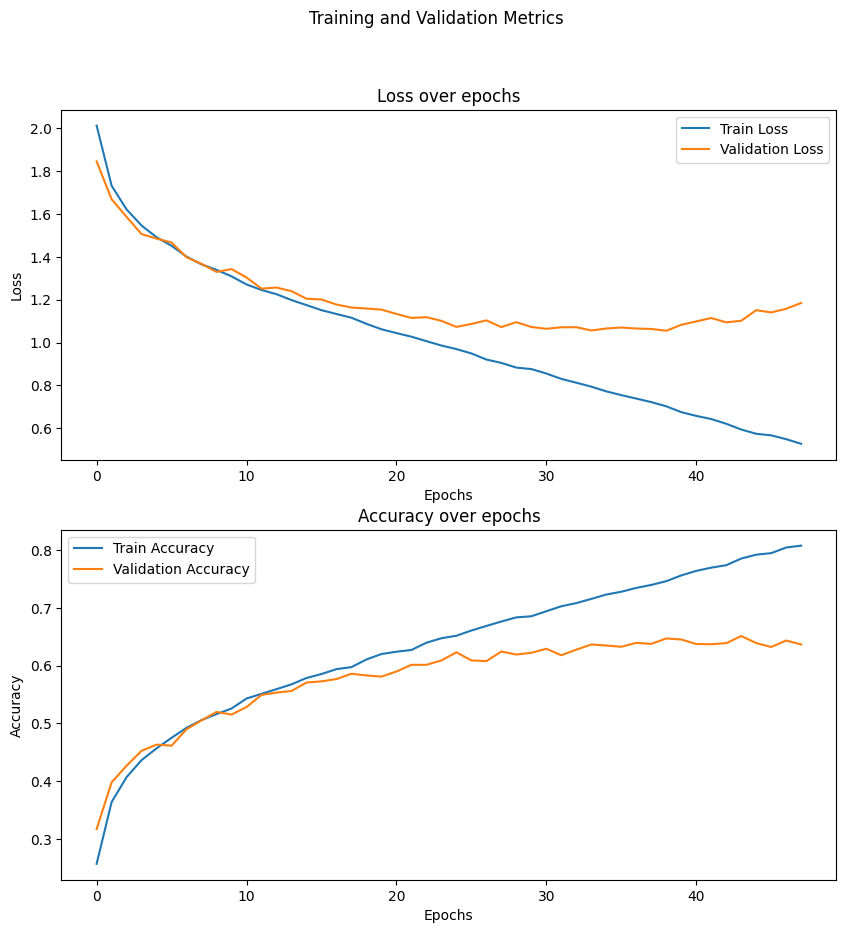

100%|██████████| 20/20 [00:01<00:00, 10.54it/s]

Test Loss: 1.0451
Test Accuracy: 0.6536


In [14]:
learned_postional_embedding = PatchEmbeddingLearnedPositionalEmbedding(EMBEDING_DIMENTION, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS)
model_learned = training_loop(learned_postional_embedding, 'best_model_learned_embedding.pt')
test_model(model_learned, 'best_model_learned_embedding.pt')

  2%|▏         | 1/50 [00:25<21:00, 25.73s/it]

Epoch 1: New best model saved with val_loss: 1.9551
------------------------------
Train Loss EPOCH 1: 2.0498
Valid Loss EPOCH 1: 1.9551
Train Accuracy EPOCH 1: 0.2359
Valid Accuracy EPOCH 1: 0.2692
------------------------------


  4%|▍         | 2/50 [00:51<20:35, 25.75s/it]

Epoch 2: New best model saved with val_loss: 1.8915
------------------------------
Train Loss EPOCH 2: 1.9195
Valid Loss EPOCH 2: 1.8915
Train Accuracy EPOCH 2: 0.2819
Valid Accuracy EPOCH 2: 0.2938
------------------------------


  6%|▌         | 3/50 [01:16<20:03, 25.61s/it]

Epoch 3: New best model saved with val_loss: 1.8397
------------------------------
Train Loss EPOCH 3: 1.8485
Valid Loss EPOCH 3: 1.8397
Train Accuracy EPOCH 3: 0.3095
Valid Accuracy EPOCH 3: 0.3100
------------------------------


  8%|▊         | 4/50 [01:42<19:31, 25.46s/it]

------------------------------
Train Loss EPOCH 4: 1.8015
Valid Loss EPOCH 4: 1.8582
Train Accuracy EPOCH 4: 0.3300
Valid Accuracy EPOCH 4: 0.3214
------------------------------


 10%|█         | 5/50 [02:07<19:08, 25.52s/it]

Epoch 5: New best model saved with val_loss: 1.7579
------------------------------
Train Loss EPOCH 5: 1.7602
Valid Loss EPOCH 5: 1.7579
Train Accuracy EPOCH 5: 0.3473
Valid Accuracy EPOCH 5: 0.3496
------------------------------


 12%|█▏        | 6/50 [02:33<18:42, 25.51s/it]

Epoch 6: New best model saved with val_loss: 1.6952
------------------------------
Train Loss EPOCH 6: 1.7273
Valid Loss EPOCH 6: 1.6952
Train Accuracy EPOCH 6: 0.3596
Valid Accuracy EPOCH 6: 0.3794
------------------------------


 14%|█▍        | 7/50 [02:58<18:16, 25.49s/it]

------------------------------
Train Loss EPOCH 7: 1.6933
Valid Loss EPOCH 7: 1.7048
Train Accuracy EPOCH 7: 0.3731
Valid Accuracy EPOCH 7: 0.3684
------------------------------


 16%|█▌        | 8/50 [03:24<17:49, 25.47s/it]

Epoch 8: New best model saved with val_loss: 1.6276
------------------------------
Train Loss EPOCH 8: 1.6710
Valid Loss EPOCH 8: 1.6276
Train Accuracy EPOCH 8: 0.3850
Valid Accuracy EPOCH 8: 0.4034
------------------------------


 18%|█▊        | 9/50 [03:49<17:22, 25.43s/it]

Epoch 9: New best model saved with val_loss: 1.5957
------------------------------
Train Loss EPOCH 9: 1.6284
Valid Loss EPOCH 9: 1.5957
Train Accuracy EPOCH 9: 0.4023
Valid Accuracy EPOCH 9: 0.4220
------------------------------


 20%|██        | 10/50 [04:15<16:58, 25.47s/it]

------------------------------
Train Loss EPOCH 10: 1.6002
Valid Loss EPOCH 10: 1.6075
Train Accuracy EPOCH 10: 0.4144
Valid Accuracy EPOCH 10: 0.4052
------------------------------


 22%|██▏       | 11/50 [04:40<16:32, 25.45s/it]

Epoch 11: New best model saved with val_loss: 1.5469
------------------------------
Train Loss EPOCH 11: 1.5743
Valid Loss EPOCH 11: 1.5469
Train Accuracy EPOCH 11: 0.4255
Valid Accuracy EPOCH 11: 0.4384
------------------------------


 24%|██▍       | 12/50 [05:05<16:06, 25.43s/it]

------------------------------
Train Loss EPOCH 12: 1.5512
Valid Loss EPOCH 12: 1.5533
Train Accuracy EPOCH 12: 0.4339
Valid Accuracy EPOCH 12: 0.4328
------------------------------


 26%|██▌       | 13/50 [05:31<15:41, 25.44s/it]

Epoch 13: New best model saved with val_loss: 1.5411
------------------------------
Train Loss EPOCH 13: 1.5211
Valid Loss EPOCH 13: 1.5411
Train Accuracy EPOCH 13: 0.4452
Valid Accuracy EPOCH 13: 0.4364
------------------------------


 28%|██▊       | 14/50 [05:56<15:17, 25.48s/it]

Epoch 14: New best model saved with val_loss: 1.5360
------------------------------
Train Loss EPOCH 14: 1.5187
Valid Loss EPOCH 14: 1.5360
Train Accuracy EPOCH 14: 0.4471
Valid Accuracy EPOCH 14: 0.4390
------------------------------


 30%|███       | 15/50 [06:22<14:51, 25.47s/it]

Epoch 15: New best model saved with val_loss: 1.4991
------------------------------
Train Loss EPOCH 15: 1.4953
Valid Loss EPOCH 15: 1.4991
Train Accuracy EPOCH 15: 0.4555
Valid Accuracy EPOCH 15: 0.4582
------------------------------


 32%|███▏      | 16/50 [06:47<14:27, 25.52s/it]

Epoch 16: New best model saved with val_loss: 1.4803
------------------------------
Train Loss EPOCH 16: 1.4669
Valid Loss EPOCH 16: 1.4803
Train Accuracy EPOCH 16: 0.4682
Valid Accuracy EPOCH 16: 0.4666
------------------------------


 34%|███▍      | 17/50 [07:13<14:00, 25.46s/it]

Epoch 17: New best model saved with val_loss: 1.4537
------------------------------
Train Loss EPOCH 17: 1.4437
Valid Loss EPOCH 17: 1.4537
Train Accuracy EPOCH 17: 0.4741
Valid Accuracy EPOCH 17: 0.4766
------------------------------


 36%|███▌      | 18/50 [07:38<13:36, 25.50s/it]

Epoch 18: New best model saved with val_loss: 1.4231
------------------------------
Train Loss EPOCH 18: 1.4325
Valid Loss EPOCH 18: 1.4231
Train Accuracy EPOCH 18: 0.4788
Valid Accuracy EPOCH 18: 0.4880
------------------------------


 38%|███▊      | 19/50 [08:04<13:10, 25.49s/it]

------------------------------
Train Loss EPOCH 19: 1.4293
Valid Loss EPOCH 19: 1.4409
Train Accuracy EPOCH 19: 0.4826
Valid Accuracy EPOCH 19: 0.4776
------------------------------


 40%|████      | 20/50 [08:29<12:45, 25.52s/it]

------------------------------
Train Loss EPOCH 20: 1.4184
Valid Loss EPOCH 20: 1.4319
Train Accuracy EPOCH 20: 0.4836
Valid Accuracy EPOCH 20: 0.4786
------------------------------


 42%|████▏     | 21/50 [08:55<12:19, 25.51s/it]

Epoch 21: New best model saved with val_loss: 1.3814
------------------------------
Train Loss EPOCH 21: 1.3854
Valid Loss EPOCH 21: 1.3814
Train Accuracy EPOCH 21: 0.5001
Valid Accuracy EPOCH 21: 0.5008
------------------------------


 44%|████▍     | 22/50 [09:20<11:53, 25.49s/it]

Epoch 22: New best model saved with val_loss: 1.3671
------------------------------
Train Loss EPOCH 22: 1.3703
Valid Loss EPOCH 22: 1.3671
Train Accuracy EPOCH 22: 0.5042
Valid Accuracy EPOCH 22: 0.5004
------------------------------


 46%|████▌     | 23/50 [09:46<11:28, 25.50s/it]

Epoch 23: New best model saved with val_loss: 1.3663
------------------------------
Train Loss EPOCH 23: 1.3585
Valid Loss EPOCH 23: 1.3663
Train Accuracy EPOCH 23: 0.5066
Valid Accuracy EPOCH 23: 0.5100
------------------------------


 48%|████▊     | 24/50 [10:12<11:06, 25.64s/it]

------------------------------
Train Loss EPOCH 24: 1.3556
Valid Loss EPOCH 24: 1.3776
Train Accuracy EPOCH 24: 0.5060
Valid Accuracy EPOCH 24: 0.5072
------------------------------


 50%|█████     | 25/50 [10:39<10:50, 26.01s/it]

Epoch 25: New best model saved with val_loss: 1.3656
------------------------------
Train Loss EPOCH 25: 1.3352
Valid Loss EPOCH 25: 1.3656
Train Accuracy EPOCH 25: 0.5167
Valid Accuracy EPOCH 25: 0.5078
------------------------------


 52%|█████▏    | 26/50 [11:05<10:26, 26.09s/it]

Epoch 26: New best model saved with val_loss: 1.3377
------------------------------
Train Loss EPOCH 26: 1.3282
Valid Loss EPOCH 26: 1.3377
Train Accuracy EPOCH 26: 0.5204
Valid Accuracy EPOCH 26: 0.5180
------------------------------


 54%|█████▍    | 27/50 [11:30<09:53, 25.79s/it]

------------------------------
Train Loss EPOCH 27: 1.3121
Valid Loss EPOCH 27: 1.3456
Train Accuracy EPOCH 27: 0.5261
Valid Accuracy EPOCH 27: 0.5116
------------------------------


 56%|█████▌    | 28/50 [11:57<09:32, 26.03s/it]

Epoch 28: New best model saved with val_loss: 1.3250
------------------------------
Train Loss EPOCH 28: 1.2966
Valid Loss EPOCH 28: 1.3250
Train Accuracy EPOCH 28: 0.5327
Valid Accuracy EPOCH 28: 0.5244
------------------------------


 58%|█████▊    | 29/50 [12:22<09:05, 25.96s/it]

------------------------------
Train Loss EPOCH 29: 1.2907
Valid Loss EPOCH 29: 1.3515
Train Accuracy EPOCH 29: 0.5364
Valid Accuracy EPOCH 29: 0.5092
------------------------------


 60%|██████    | 30/50 [12:48<08:39, 25.95s/it]

Epoch 30: New best model saved with val_loss: 1.3190
------------------------------
Train Loss EPOCH 30: 1.2809
Valid Loss EPOCH 30: 1.3190
Train Accuracy EPOCH 30: 0.5374
Valid Accuracy EPOCH 30: 0.5266
------------------------------


 62%|██████▏   | 31/50 [13:15<08:16, 26.13s/it]

Epoch 31: New best model saved with val_loss: 1.3153
------------------------------
Train Loss EPOCH 31: 1.2675
Valid Loss EPOCH 31: 1.3153
Train Accuracy EPOCH 31: 0.5421
Valid Accuracy EPOCH 31: 0.5318
------------------------------


 64%|██████▍   | 32/50 [13:41<07:49, 26.07s/it]

Epoch 32: New best model saved with val_loss: 1.3086
------------------------------
Train Loss EPOCH 32: 1.2599
Valid Loss EPOCH 32: 1.3086
Train Accuracy EPOCH 32: 0.5429
Valid Accuracy EPOCH 32: 0.5328
------------------------------


 66%|██████▌   | 33/50 [14:07<07:21, 25.96s/it]

------------------------------
Train Loss EPOCH 33: 1.2351
Valid Loss EPOCH 33: 1.3347
Train Accuracy EPOCH 33: 0.5585
Valid Accuracy EPOCH 33: 0.5216
------------------------------


 68%|██████▊   | 34/50 [14:33<06:55, 25.97s/it]

------------------------------
Train Loss EPOCH 34: 1.2316
Valid Loss EPOCH 34: 1.3223
Train Accuracy EPOCH 34: 0.5556
Valid Accuracy EPOCH 34: 0.5350
------------------------------


 70%|███████   | 35/50 [14:58<06:28, 25.88s/it]

Epoch 35: New best model saved with val_loss: 1.3077
------------------------------
Train Loss EPOCH 35: 1.2136
Valid Loss EPOCH 35: 1.3077
Train Accuracy EPOCH 35: 0.5610
Valid Accuracy EPOCH 35: 0.5328
------------------------------


 72%|███████▏  | 36/50 [15:24<06:02, 25.91s/it]

Epoch 36: New best model saved with val_loss: 1.2830
------------------------------
Train Loss EPOCH 36: 1.2076
Valid Loss EPOCH 36: 1.2830
Train Accuracy EPOCH 36: 0.5629
Valid Accuracy EPOCH 36: 0.5508
------------------------------


 74%|███████▍  | 37/50 [15:50<05:36, 25.86s/it]

------------------------------
Train Loss EPOCH 37: 1.1997
Valid Loss EPOCH 37: 1.2967
Train Accuracy EPOCH 37: 0.5691
Valid Accuracy EPOCH 37: 0.5384
------------------------------


 76%|███████▌  | 38/50 [16:16<05:10, 25.86s/it]

Epoch 38: New best model saved with val_loss: 1.2735
------------------------------
Train Loss EPOCH 38: 1.1932
Valid Loss EPOCH 38: 1.2735
Train Accuracy EPOCH 38: 0.5689
Valid Accuracy EPOCH 38: 0.5464
------------------------------


 78%|███████▊  | 39/50 [16:42<04:43, 25.81s/it]

Epoch 39: New best model saved with val_loss: 1.2733
------------------------------
Train Loss EPOCH 39: 1.1764
Valid Loss EPOCH 39: 1.2733
Train Accuracy EPOCH 39: 0.5755
Valid Accuracy EPOCH 39: 0.5462
------------------------------


 80%|████████  | 40/50 [17:07<04:18, 25.82s/it]

Epoch 40: New best model saved with val_loss: 1.2717
------------------------------
Train Loss EPOCH 40: 1.1640
Valid Loss EPOCH 40: 1.2717
Train Accuracy EPOCH 40: 0.5838
Valid Accuracy EPOCH 40: 0.5494
------------------------------


 82%|████████▏ | 41/50 [17:33<03:52, 25.84s/it]

------------------------------
Train Loss EPOCH 41: 1.1597
Valid Loss EPOCH 41: 1.2774
Train Accuracy EPOCH 41: 0.5833
Valid Accuracy EPOCH 41: 0.5402
------------------------------


 84%|████████▍ | 42/50 [17:59<03:27, 25.88s/it]

------------------------------
Train Loss EPOCH 42: 1.1512
Valid Loss EPOCH 42: 1.2781
Train Accuracy EPOCH 42: 0.5831
Valid Accuracy EPOCH 42: 0.5408
------------------------------


 86%|████████▌ | 43/50 [18:25<03:00, 25.82s/it]

Epoch 43: New best model saved with val_loss: 1.2623
------------------------------
Train Loss EPOCH 43: 1.1372
Valid Loss EPOCH 43: 1.2623
Train Accuracy EPOCH 43: 0.5896
Valid Accuracy EPOCH 43: 0.5514
------------------------------


 88%|████████▊ | 44/50 [18:51<02:35, 25.84s/it]

------------------------------
Train Loss EPOCH 44: 1.1268
Valid Loss EPOCH 44: 1.2633
Train Accuracy EPOCH 44: 0.5917
Valid Accuracy EPOCH 44: 0.5496
------------------------------


 90%|█████████ | 45/50 [19:16<02:08, 25.77s/it]

------------------------------
Train Loss EPOCH 45: 1.1223
Valid Loss EPOCH 45: 1.2667
Train Accuracy EPOCH 45: 0.5956
Valid Accuracy EPOCH 45: 0.5586
------------------------------


 92%|█████████▏| 46/50 [19:42<01:43, 25.79s/it]

------------------------------
Train Loss EPOCH 46: 1.0963
Valid Loss EPOCH 46: 1.2647
Train Accuracy EPOCH 46: 0.6035
Valid Accuracy EPOCH 46: 0.5552
------------------------------


 94%|█████████▍| 47/50 [20:08<01:17, 25.74s/it]

Epoch 47: New best model saved with val_loss: 1.2500
------------------------------
Train Loss EPOCH 47: 1.0986
Valid Loss EPOCH 47: 1.2500
Train Accuracy EPOCH 47: 0.6024
Valid Accuracy EPOCH 47: 0.5610
------------------------------


 96%|█████████▌| 48/50 [20:34<00:51, 25.75s/it]

------------------------------
Train Loss EPOCH 48: 1.0862
Valid Loss EPOCH 48: 1.2632
Train Accuracy EPOCH 48: 0.6084
Valid Accuracy EPOCH 48: 0.5582
------------------------------


 98%|█████████▊| 49/50 [20:59<00:25, 25.78s/it]

------------------------------
Train Loss EPOCH 49: 1.0685
Valid Loss EPOCH 49: 1.2546
Train Accuracy EPOCH 49: 0.6135
Valid Accuracy EPOCH 49: 0.5612
------------------------------


100%|██████████| 50/50 [21:25<00:00, 25.72s/it]


------------------------------
Train Loss EPOCH 50: 1.0689
Valid Loss EPOCH 50: 1.2625
Train Accuracy EPOCH 50: 0.6145
Valid Accuracy EPOCH 50: 0.5604
------------------------------
Completed all epochs without early stopping.
Training Time: 1285.80s


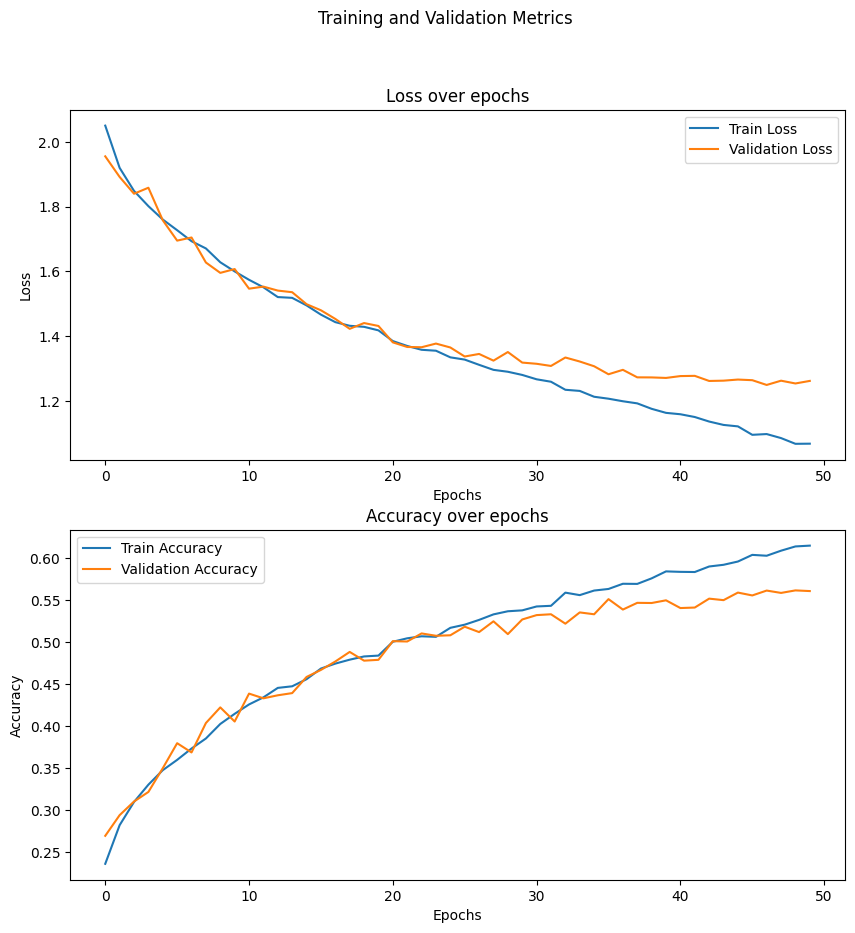

100%|██████████| 20/20 [00:02<00:00,  9.91it/s]

Test Loss: 1.3470
Test Accuracy: 0.5261


In [15]:
no_postional_embedding = PatchEmbeddingNoPositionalEmbedding(EMBEDING_DIMENTION, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS)
model_no_embedding = training_loop(no_postional_embedding, 'best_model_no_embedding.pt')
test_model(model_no_embedding, 'best_model_no_embedding.pt')

Order is  2


  2%|▏         | 1/50 [00:24<20:16, 24.83s/it]

Epoch 1: New best model saved with val_loss: 1.9737
------------------------------
Train Loss EPOCH 1: 2.1039
Valid Loss EPOCH 1: 1.9737
Train Accuracy EPOCH 1: 0.2196
Valid Accuracy EPOCH 1: 0.2672
------------------------------


  4%|▍         | 2/50 [00:49<19:40, 24.59s/it]

Epoch 2: New best model saved with val_loss: 1.8757
------------------------------
Train Loss EPOCH 2: 1.8964
Valid Loss EPOCH 2: 1.8757
Train Accuracy EPOCH 2: 0.2926
Valid Accuracy EPOCH 2: 0.3164
------------------------------


  6%|▌         | 3/50 [01:13<19:09, 24.46s/it]

Epoch 3: New best model saved with val_loss: 1.7420
------------------------------
Train Loss EPOCH 3: 1.7769
Valid Loss EPOCH 3: 1.7420
Train Accuracy EPOCH 3: 0.3448
Valid Accuracy EPOCH 3: 0.3632
------------------------------


  8%|▊         | 4/50 [01:37<18:42, 24.40s/it]

Epoch 4: New best model saved with val_loss: 1.6756
------------------------------
Train Loss EPOCH 4: 1.7136
Valid Loss EPOCH 4: 1.6756
Train Accuracy EPOCH 4: 0.3705
Valid Accuracy EPOCH 4: 0.3866
------------------------------


 10%|█         | 5/50 [02:02<18:16, 24.38s/it]

Epoch 5: New best model saved with val_loss: 1.6196
------------------------------
Train Loss EPOCH 5: 1.6339
Valid Loss EPOCH 5: 1.6196
Train Accuracy EPOCH 5: 0.4037
Valid Accuracy EPOCH 5: 0.4080
------------------------------


 12%|█▏        | 6/50 [02:26<17:52, 24.38s/it]

Epoch 6: New best model saved with val_loss: 1.5717
------------------------------
Train Loss EPOCH 6: 1.5881
Valid Loss EPOCH 6: 1.5717
Train Accuracy EPOCH 6: 0.4218
Valid Accuracy EPOCH 6: 0.4276
------------------------------


 14%|█▍        | 7/50 [02:50<17:28, 24.38s/it]

Epoch 7: New best model saved with val_loss: 1.5519
------------------------------
Train Loss EPOCH 7: 1.5451
Valid Loss EPOCH 7: 1.5519
Train Accuracy EPOCH 7: 0.4376
Valid Accuracy EPOCH 7: 0.4326
------------------------------


 16%|█▌        | 8/50 [03:15<17:01, 24.32s/it]

Epoch 8: New best model saved with val_loss: 1.4963
------------------------------
Train Loss EPOCH 8: 1.5123
Valid Loss EPOCH 8: 1.4963
Train Accuracy EPOCH 8: 0.4516
Valid Accuracy EPOCH 8: 0.4602
------------------------------


 18%|█▊        | 9/50 [03:39<16:35, 24.28s/it]

Epoch 9: New best model saved with val_loss: 1.4628
------------------------------
Train Loss EPOCH 9: 1.4819
Valid Loss EPOCH 9: 1.4628
Train Accuracy EPOCH 9: 0.4626
Valid Accuracy EPOCH 9: 0.4694
------------------------------


 20%|██        | 10/50 [04:03<16:10, 24.26s/it]

Epoch 10: New best model saved with val_loss: 1.4378
------------------------------
Train Loss EPOCH 10: 1.4555
Valid Loss EPOCH 10: 1.4378
Train Accuracy EPOCH 10: 0.4711
Valid Accuracy EPOCH 10: 0.4768
------------------------------


 22%|██▏       | 11/50 [04:27<15:47, 24.30s/it]

Epoch 11: New best model saved with val_loss: 1.4323
------------------------------
Train Loss EPOCH 11: 1.4331
Valid Loss EPOCH 11: 1.4323
Train Accuracy EPOCH 11: 0.4800
Valid Accuracy EPOCH 11: 0.4798
------------------------------


 24%|██▍       | 12/50 [04:52<15:20, 24.24s/it]

Epoch 12: New best model saved with val_loss: 1.3858
------------------------------
Train Loss EPOCH 12: 1.4084
Valid Loss EPOCH 12: 1.3858
Train Accuracy EPOCH 12: 0.4902
Valid Accuracy EPOCH 12: 0.5014
------------------------------


 26%|██▌       | 13/50 [05:16<14:58, 24.27s/it]

Epoch 13: New best model saved with val_loss: 1.3803
------------------------------
Train Loss EPOCH 13: 1.3938
Valid Loss EPOCH 13: 1.3803
Train Accuracy EPOCH 13: 0.4954
Valid Accuracy EPOCH 13: 0.5042
------------------------------


 28%|██▊       | 14/50 [05:40<14:33, 24.26s/it]

------------------------------
Train Loss EPOCH 14: 1.3699
Valid Loss EPOCH 14: 1.3932
Train Accuracy EPOCH 14: 0.5032
Valid Accuracy EPOCH 14: 0.4872
------------------------------


 30%|███       | 15/50 [06:05<14:11, 24.34s/it]

Epoch 15: New best model saved with val_loss: 1.3528
------------------------------
Train Loss EPOCH 15: 1.3456
Valid Loss EPOCH 15: 1.3528
Train Accuracy EPOCH 15: 0.5118
Valid Accuracy EPOCH 15: 0.5112
------------------------------


 32%|███▏      | 16/50 [06:30<13:53, 24.52s/it]

Epoch 16: New best model saved with val_loss: 1.3196
------------------------------
Train Loss EPOCH 16: 1.3274
Valid Loss EPOCH 16: 1.3196
Train Accuracy EPOCH 16: 0.5187
Valid Accuracy EPOCH 16: 0.5270
------------------------------


 34%|███▍      | 17/50 [06:54<13:23, 24.35s/it]

------------------------------
Train Loss EPOCH 17: 1.3078
Valid Loss EPOCH 17: 1.3506
Train Accuracy EPOCH 17: 0.5281
Valid Accuracy EPOCH 17: 0.5128
------------------------------


 36%|███▌      | 18/50 [07:17<12:53, 24.17s/it]

------------------------------
Train Loss EPOCH 18: 1.2892
Valid Loss EPOCH 18: 1.3366
Train Accuracy EPOCH 18: 0.5321
Valid Accuracy EPOCH 18: 0.5268
------------------------------


 38%|███▊      | 19/50 [07:41<12:26, 24.07s/it]

Epoch 19: New best model saved with val_loss: 1.2980
------------------------------
Train Loss EPOCH 19: 1.2756
Valid Loss EPOCH 19: 1.2980
Train Accuracy EPOCH 19: 0.5365
Valid Accuracy EPOCH 19: 0.5250
------------------------------


 40%|████      | 20/50 [08:05<11:59, 23.99s/it]

Epoch 20: New best model saved with val_loss: 1.2624
------------------------------
Train Loss EPOCH 20: 1.2542
Valid Loss EPOCH 20: 1.2624
Train Accuracy EPOCH 20: 0.5465
Valid Accuracy EPOCH 20: 0.5460
------------------------------


 42%|████▏     | 21/50 [08:29<11:40, 24.14s/it]

------------------------------
Train Loss EPOCH 21: 1.2378
Valid Loss EPOCH 21: 1.3034
Train Accuracy EPOCH 21: 0.5536
Valid Accuracy EPOCH 21: 0.5334
------------------------------


 44%|████▍     | 22/50 [08:54<11:19, 24.25s/it]

------------------------------
Train Loss EPOCH 22: 1.2277
Valid Loss EPOCH 22: 1.2646
Train Accuracy EPOCH 22: 0.5574
Valid Accuracy EPOCH 22: 0.5440
------------------------------


 46%|████▌     | 23/50 [09:19<11:00, 24.46s/it]

------------------------------
Train Loss EPOCH 23: 1.2073
Valid Loss EPOCH 23: 1.2650
Train Accuracy EPOCH 23: 0.5634
Valid Accuracy EPOCH 23: 0.5500
------------------------------


 48%|████▊     | 24/50 [09:44<10:40, 24.64s/it]

Epoch 24: New best model saved with val_loss: 1.2241
------------------------------
Train Loss EPOCH 24: 1.1996
Valid Loss EPOCH 24: 1.2241
Train Accuracy EPOCH 24: 0.5664
Valid Accuracy EPOCH 24: 0.5630
------------------------------


 50%|█████     | 25/50 [10:09<10:19, 24.79s/it]

------------------------------
Train Loss EPOCH 25: 1.1857
Valid Loss EPOCH 25: 1.2403
Train Accuracy EPOCH 25: 0.5716
Valid Accuracy EPOCH 25: 0.5564
------------------------------


 52%|█████▏    | 26/50 [10:33<09:50, 24.62s/it]

Epoch 26: New best model saved with val_loss: 1.2174
------------------------------
Train Loss EPOCH 26: 1.1754
Valid Loss EPOCH 26: 1.2174
Train Accuracy EPOCH 26: 0.5774
Valid Accuracy EPOCH 26: 0.5666
------------------------------


 54%|█████▍    | 27/50 [10:57<09:23, 24.48s/it]

------------------------------
Train Loss EPOCH 27: 1.1529
Valid Loss EPOCH 27: 1.2248
Train Accuracy EPOCH 27: 0.5837
Valid Accuracy EPOCH 27: 0.5612
------------------------------


 56%|█████▌    | 28/50 [11:21<08:55, 24.34s/it]

------------------------------
Train Loss EPOCH 28: 1.1466
Valid Loss EPOCH 28: 1.2267
Train Accuracy EPOCH 28: 0.5841
Valid Accuracy EPOCH 28: 0.5654
------------------------------


 58%|█████▊    | 29/50 [11:46<08:29, 24.27s/it]

Epoch 29: New best model saved with val_loss: 1.2124
------------------------------
Train Loss EPOCH 29: 1.1317
Valid Loss EPOCH 29: 1.2124
Train Accuracy EPOCH 29: 0.5910
Valid Accuracy EPOCH 29: 0.5594
------------------------------


 60%|██████    | 30/50 [12:10<08:03, 24.17s/it]

------------------------------
Train Loss EPOCH 30: 1.1222
Valid Loss EPOCH 30: 1.2352
Train Accuracy EPOCH 30: 0.5940
Valid Accuracy EPOCH 30: 0.5508
------------------------------


 62%|██████▏   | 31/50 [12:34<07:40, 24.23s/it]

Epoch 31: New best model saved with val_loss: 1.2093
------------------------------
Train Loss EPOCH 31: 1.0937
Valid Loss EPOCH 31: 1.2093
Train Accuracy EPOCH 31: 0.6057
Valid Accuracy EPOCH 31: 0.5748
------------------------------


 64%|██████▍   | 32/50 [12:58<07:14, 24.16s/it]

Epoch 32: New best model saved with val_loss: 1.2033
------------------------------
Train Loss EPOCH 32: 1.0872
Valid Loss EPOCH 32: 1.2033
Train Accuracy EPOCH 32: 0.6086
Valid Accuracy EPOCH 32: 0.5738
------------------------------


 66%|██████▌   | 33/50 [13:22<06:51, 24.19s/it]

Epoch 33: New best model saved with val_loss: 1.1996
------------------------------
Train Loss EPOCH 33: 1.0784
Valid Loss EPOCH 33: 1.1996
Train Accuracy EPOCH 33: 0.6113
Valid Accuracy EPOCH 33: 0.5722
------------------------------


 68%|██████▊   | 34/50 [13:47<06:31, 24.44s/it]

Epoch 34: New best model saved with val_loss: 1.1796
------------------------------
Train Loss EPOCH 34: 1.0642
Valid Loss EPOCH 34: 1.1796
Train Accuracy EPOCH 34: 0.6163
Valid Accuracy EPOCH 34: 0.5882
------------------------------


 70%|███████   | 35/50 [14:13<06:11, 24.77s/it]

Epoch 35: New best model saved with val_loss: 1.1782
------------------------------
Train Loss EPOCH 35: 1.0563
Valid Loss EPOCH 35: 1.1782
Train Accuracy EPOCH 35: 0.6192
Valid Accuracy EPOCH 35: 0.5774
------------------------------


 72%|███████▏  | 36/50 [14:37<05:46, 24.73s/it]

Epoch 36: New best model saved with val_loss: 1.1658
------------------------------
Train Loss EPOCH 36: 1.0378
Valid Loss EPOCH 36: 1.1658
Train Accuracy EPOCH 36: 0.6272
Valid Accuracy EPOCH 36: 0.5794
------------------------------


 74%|███████▍  | 37/50 [15:02<05:21, 24.69s/it]

------------------------------
Train Loss EPOCH 37: 1.0236
Valid Loss EPOCH 37: 1.1820
Train Accuracy EPOCH 37: 0.6304
Valid Accuracy EPOCH 37: 0.5782
------------------------------


 76%|███████▌  | 38/50 [15:27<04:56, 24.71s/it]

------------------------------
Train Loss EPOCH 38: 1.0153
Valid Loss EPOCH 38: 1.1792
Train Accuracy EPOCH 38: 0.6334
Valid Accuracy EPOCH 38: 0.5784
------------------------------


 78%|███████▊  | 39/50 [15:51<04:31, 24.68s/it]

Epoch 39: New best model saved with val_loss: 1.1590
------------------------------
Train Loss EPOCH 39: 1.0040
Valid Loss EPOCH 39: 1.1590
Train Accuracy EPOCH 39: 0.6386
Valid Accuracy EPOCH 39: 0.5906
------------------------------


 80%|████████  | 40/50 [16:16<04:06, 24.67s/it]

------------------------------
Train Loss EPOCH 40: 0.9905
Valid Loss EPOCH 40: 1.1699
Train Accuracy EPOCH 40: 0.6426
Valid Accuracy EPOCH 40: 0.5870
------------------------------


 82%|████████▏ | 41/50 [16:41<03:42, 24.74s/it]

------------------------------
Train Loss EPOCH 41: 1.0026
Valid Loss EPOCH 41: 1.1776
Train Accuracy EPOCH 41: 0.6372
Valid Accuracy EPOCH 41: 0.5860
------------------------------


 84%|████████▍ | 42/50 [17:05<03:17, 24.69s/it]

------------------------------
Train Loss EPOCH 42: 0.9762
Valid Loss EPOCH 42: 1.1659
Train Accuracy EPOCH 42: 0.6483
Valid Accuracy EPOCH 42: 0.5870
------------------------------


 86%|████████▌ | 43/50 [17:30<02:52, 24.67s/it]

------------------------------
Train Loss EPOCH 43: 0.9632
Valid Loss EPOCH 43: 1.1725
Train Accuracy EPOCH 43: 0.6526
Valid Accuracy EPOCH 43: 0.5962
------------------------------


 88%|████████▊ | 44/50 [17:55<02:27, 24.66s/it]

Epoch 44: New best model saved with val_loss: 1.1507
------------------------------
Train Loss EPOCH 44: 0.9403
Valid Loss EPOCH 44: 1.1507
Train Accuracy EPOCH 44: 0.6615
Valid Accuracy EPOCH 44: 0.5964
------------------------------


 90%|█████████ | 45/50 [18:19<02:03, 24.61s/it]

------------------------------
Train Loss EPOCH 45: 0.9306
Valid Loss EPOCH 45: 1.1968
Train Accuracy EPOCH 45: 0.6641
Valid Accuracy EPOCH 45: 0.5932
------------------------------


 92%|█████████▏| 46/50 [18:44<01:38, 24.66s/it]

Epoch 46: New best model saved with val_loss: 1.1181
------------------------------
Train Loss EPOCH 46: 0.9263
Valid Loss EPOCH 46: 1.1181
Train Accuracy EPOCH 46: 0.6655
Valid Accuracy EPOCH 46: 0.6088
------------------------------


 94%|█████████▍| 47/50 [19:09<01:14, 24.80s/it]

------------------------------
Train Loss EPOCH 47: 0.9145
Valid Loss EPOCH 47: 1.1476
Train Accuracy EPOCH 47: 0.6693
Valid Accuracy EPOCH 47: 0.6084
------------------------------


 96%|█████████▌| 48/50 [19:35<00:49, 24.98s/it]

------------------------------
Train Loss EPOCH 48: 0.8968
Valid Loss EPOCH 48: 1.1806
Train Accuracy EPOCH 48: 0.6767
Valid Accuracy EPOCH 48: 0.5920
------------------------------


 98%|█████████▊| 49/50 [19:59<00:24, 24.92s/it]

------------------------------
Train Loss EPOCH 49: 0.9111
Valid Loss EPOCH 49: 1.1714
Train Accuracy EPOCH 49: 0.6682
Valid Accuracy EPOCH 49: 0.5896
------------------------------


100%|██████████| 50/50 [20:24<00:00, 24.49s/it]


------------------------------
Train Loss EPOCH 50: 0.8799
Valid Loss EPOCH 50: 1.1784
Train Accuracy EPOCH 50: 0.6790
Valid Accuracy EPOCH 50: 0.5970
------------------------------
Completed all epochs without early stopping.
Training Time: 1224.45s


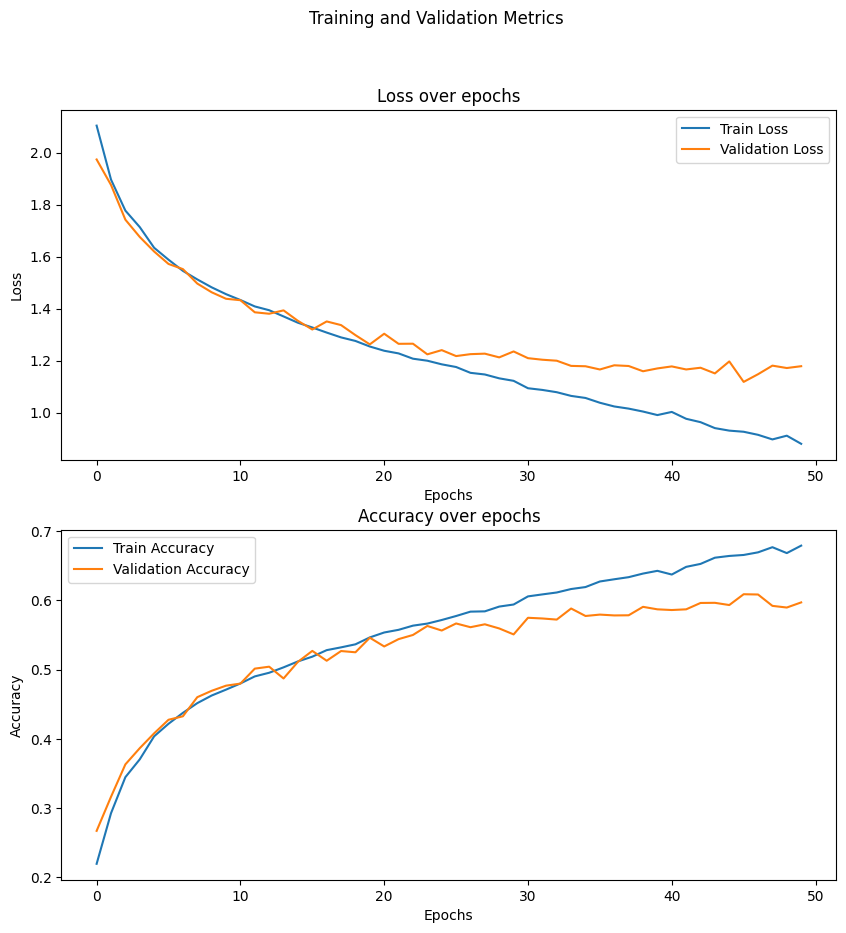

100%|██████████| 20/20 [00:01<00:00, 10.25it/s]

Test Loss: 1.1841
Test Accuracy: 0.5888


In [16]:
hilbert_embedding = PatchEmbeddingHilbertPositionalEmbedding(EMBEDING_DIMENTION, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS, IMAGE_SIZE)
model_hilbert = training_loop(hilbert_embedding, 'hilbert_embedding.pt')
test_model(model_hilbert, 'hilbert_embedding.pt')